# CPSC 330 - Applied Machine Learning 

## Homework 3: Preprocessing 
### Associated lectures: [Lectures 4, 5, 6](https://github.com/UBC-CS/cpsc330-2023s/tree/main/lectures) 

**Due date: Monday, Feb 5, 11:59pm. See the [HW schedule](https://github.com/UBC-CS/cpsc330-2023W2#deliverable-due-dates-tentative)**. 


## Imports 

In [49]:
from hashlib import sha1
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Instructions
<hr>

_Points: 6_

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W2/blob/master/docs/homework_instructions.md), and the summary at the end of this HW.

**You <u>may</u> work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- You can also work on your own if you prefer.
- The maximum group size is 2.
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

## Introduction <a name="in"></a>
<hr>

A crucial step when using machine learning algorithms on real-world datasets is preprocessing. This homework will give you some practice of data preprocessing and building a supervised machine learning pipeline on a real-world dataset. 

<br><br>

## Exercise 1: Introducing the dataset
<hr>

In this lab, you will be working on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#). Download the CSV and save it as `adult.csv` under the data folder in this homework folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. You can find more information on the dataset and features [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` under the data folder). 

_Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

In [50]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 

_Points: 2_

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

**Your tasks:**

1. Split the data into `train_df` (40%) and `test_df` (60%) with `random_state = 123`. Keep the target column (`income`) in the splits so that we can use it in the exploratory data analysis.  

_Usually having more data for training is a good idea. But here I'm using 40%/60% split because running cross-validation with this dataset can take a while on a modest laptop. A smaller training data means it won't take too long to train the model on your laptop. A side advantage of this would be that with a bigger test split, we'll have a more reliable estimate of the model performance!_

<div class="alert alert-warning">

Solution_1.1
    
</div>

In [51]:
train_df = None
test_df = None

train_df, test_df = train_test_split(census_df, test_size=0.60, random_state=123)

<br><br>

## Exercise 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [52]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values because they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [53]:
train_df = train_df.replace("?", np.nan)
test_df = test_df.replace("?", np.nan)
train_df.shape

(13024, 15)

In [54]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 `describe()` method

_Points: 5_

**Your tasks:**

1. Examine the output of `train_df.describe()` with `include='all'` argument and store it in a variable called `census_summary`.
2. What is the highest hours per week someone reported? Store it in a variable called `max_hours_per_week`.
3. What is the most frequently occurring occupation in this dataset? Store it in a variable called `most_freq_occupation`.
4. Store the column names of the columns with missing values as a list in a variable called `missing_vals_cols`. 
5. Store the column names of all numeric-looking columns as a list in a variable called `numeric_cols`.  

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [55]:
census_summary = train_df.describe(include = 'all')
census_summary

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
count,13024.000000,12284,1.302400e+04,13024,13024.000000,13024,12281,13024,13024,13024,13024.000000,13024.000000,13024.000000,12783,13024
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,40,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,9123,NaN,4153,NaN,5936,1649,5195,11158,8700,NaN,NaN,NaN,11717,9875
mean,38.546913,NaN,1.884759e+05,NaN,10.057432,NaN,NaN,NaN,NaN,NaN,1079.831695,86.543074,40.395654,NaN,NaN
std,13.610225,NaN,1.040895e+05,NaN,2.553084,NaN,NaN,NaN,NaN,NaN,7322.034546,403.025863,12.285347,NaN,NaN
min,17.000000,NaN,1.376900e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.170962e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.778990e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.365655e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [56]:
max_hours_per_week = train_df['hours.per.week'].max()

max_hours_per_week

99

In [57]:
most_freq_occupation = train_df['occupation'].value_counts().idxmax()

most_freq_occupation

'Prof-specialty'

In [58]:
missing_vals_cols = train_df.columns[train_df.isnull().any()].tolist()

numeric_cols = train_df.select_dtypes(include = 'number').columns.tolist()

print(missing_vals_cols)
print(numeric_cols)


['workclass', 'occupation', 'native.country']
['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Visualizing features

_Points: 5_

**Your tasks:**

1. Visualize the histograms of numeric features.  
2. From the visualizations, which features seem relevant for the given prediction task?

<div class="alert alert-warning">

Solution_2.2
    
</div>

<Figure size 3000x2000 with 0 Axes>

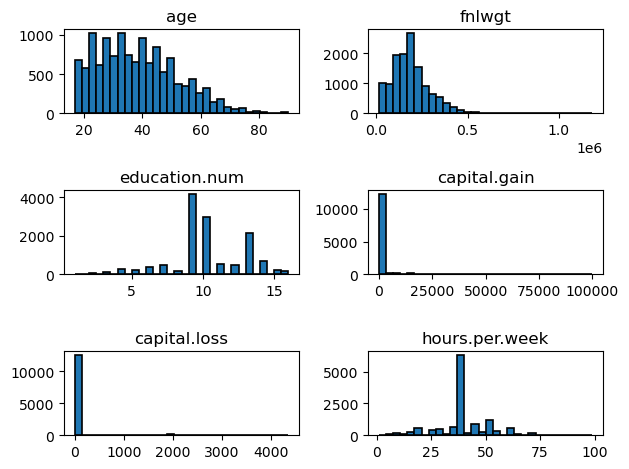

In [59]:
plt.figure(figsize=(30, 20))
train_df[numeric_cols].hist(bins = 30, edgecolor = 'black', grid = False, linewidth = 1.2)
plt.tight_layout()
plt.show()


<!-- END QUESTION -->

<br>Based on the visualization, age, education.num, and hours.per.week seem the most relevant for the prediction task. The task is to predict whether the income exceeds 50K per year or not based on the census data. 

- Age can be a major factor in predicting this since a higher age may represent more experience in an industry, suggesting higher salaries. 

- Another important variable can be education.num. A person who has a master's or PhD degree would have more knowledge and experience than a less educated individual, which can suggest higher income while working in some industry. 

- While hours.per.week might seem like another relevant feature in the sense that working a higher number of hours can lead to higher pay due to overtime, however upon looking at the histogram, the majority of the count lies in the 30 to 40-hour range, suggesting that most of the population in the data work the usual hours and working overtime may not lead to higher pay.<br>

<!-- BEGIN QUESTION -->

### 2.3 Identify transformations to apply

_Points: 13_

Before passing this data to a machine learning model, we need to apply some transformations on different features. Below we are providing possible transformations which can be applied on each column in `census_df`.  

**Your tasks:**
1. Write your justification or explanation for each row in the explanation column. An example explanation is given for the age column. 

> Note: This question is a bit open-ended. If you do not agree with the provided transformation, feel free to argue your case in the explanation. That said, in this assignment, go with the transformations provided below. 

<div class="alert alert-warning">

Solution_2.3
    
</div>

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| age | scaling |  A numeric feature with no missing values. Good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| workclass | imputation, one-hot encoding | To tackle categorical variables, we use one-hot encoding as a transformation technique. Since workclass is a categorical variable, we can convert it to binary values making it suitable for models that require numerical inputs. Furthermore, workclass also has missing values(NaN), so to handle those cases, imputation seems like an ideal technique to transform the data. |
| fnlwgt | drop | fnlwgt column does not seem relevant for prediction in this case. Hence it is better to drop the column since it does not provide us with a meaningful data. |
| education | ordinal encoding | Education variable may have an inherent order. For instance, HS-grad, bachelors, pHD, etc. These degrees are ranked based on these education levels suggesting an ordinal relationship. This transformation would also help preserve the ordinal relationship between different education categories while converting them into numeric values. |
| education.num | drop | Since we have already encoded education as ordinal, education.num becomes redundant. We can drop this column to avoid multicollinearity and simplify the dimensionality of the dataset. |
| marital.status | one-hot encoding  | Similar to workclass, marital.status is a categorical variable. To handle this, we would apply one-hot encoding and convert it to binary values making it suitable for models that require numerical inputs. |
| occupation | imputation, one-hot encoding  | occupation is also a categorical variable, hence one-hot encoding would be an ideal technique. Imputation also is a relevant transformation since there are NaN values in the dataset. |
| relationship | one-hot encoding  | relationship is again a categorical variable, we can convert it to binary values making it suitable for models that require numerical inputs. Hence one-hot encoding would be an ideal transformation technique. |
| race | drop  | race does not seem to be an appropriate predictor to predict the target variable. Hence to reduce the dimensionality and complexity of the dataset, we can drop the race column. |
| sex | one-hot encoding with "binary=True" | For this dataset, attribute sex is a categorical variable with a value of either Male or Female. Hence one-hot encoding is the ideal transformation. Moreover, the additonal argument "binary = True" specifies that only one column should be created representing the binary nature of the sex feature |
| capital.gain | scaling | From the summary of the numeric variables, we can see that capital.gain is a numeric column and has a range from 0.00 to 99999.00. The range of the values is quite different compared to other numeric features, hence it would be a good idea to apply scaling as a transformation technique.  | 
| capital.loss | scaling | capital.loss is again a numeric column and has a range from 0.00 to 4356.00. The range of the values is quite different compared to other numeric features, hence it would be good idea to apply scaling as a transformation technique. |
| hours.per.week | scaling | hours.per.week is again a numeric column and has a range from 1.00 to 99.00. The range of the values is quite different compared to other numeric features, hence it would be good idea to apply scaling as a transformation technique. |
| native.country | imputation, one-hot encoding | native.country is a categorical variable, we can convert it to binary values making it suitable for models that require numerical inputs. Furthermore, native.country has missing values(NaN), so to handle those cases, imputation seems like an ideal technique to transform the data.  | 


<!-- END QUESTION -->

<br><br>

### 2.4 Identify feature types 

_Points: 5_

**Your tasks:**
1. Based on the types of transformations you want to apply on the features, identify different feature types and store them in the variables below as lists.  

<div class="alert alert-warning">
    
Solution_2.4
    
</div>

In [60]:
# Fill in the lists below.
numeric_features = ['age', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'marital.status', 'occupation', 'relationship', 'native.country']
ordinal_features = ['education']
binary_features = ['sex']
drop_features = ['fnlwgt', 'education.num', 'race']
target = "income"


<br><br><br><br>

## Exercise 3: Baseline models 

### 3.1 Separating feature vectors and targets  

_Points: 2_

**Your tasks:**

1. Create `X_train`, `y_train`, `X_test`, `y_test` from `train_df` and `test_df`. 

<div class="alert alert-warning">
    
Solution_3.1
    
</div>

In [72]:
X_train = None
y_train = None
X_test = None
y_test = None

X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]

<br><br>

### 3.2 Dummy classifier

_Points: 2_

**Your tasks:**

1. Carry out 5-fold cross-validation using `scikit-learn`'s `cross_validate` function with `return_train_scores=True` and store the results as a dataframe named `dummy_df` where each row corresponds to the results from a cross-validation fold. 

<div class="alert alert-warning">
    
Solution_3.2
    
</div>

In [73]:
dummy_df = None 

dummy_model = DummyClassifier(strategy="most_frequent")
cv_results = cross_validate(dummy_model, X_train, y_train, cv=5, return_train_score=True)

dummy_df = pd.DataFrame(cv_results)
dummy_df

,fit_time,score_time,test_score,train_score
0,0.008013,0.005494,0.758157,0.758230
1,0.007055,0.006951,0.758157,0.758230
2,0.007210,0.005011,0.758157,0.758230
3,0.006113,0.006018,0.758157,0.758230
4,0.005865,0.005126,0.758449,0.758157


<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Discussion

_Points: 2_

**Your tasks:**

1. Hopefully, you were able to run cross-validation with dummy classifier successfully in the question above. At this point, if you train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train` would it work? Why or why not? 

<div class="alert alert-warning">
    
Solution_3.3
    
</div>

If we train sklearn's SVC model on X_train and y_train, it will not work because SVC requires numeric values as input, and variables like workclass, relationship, etc, are categorical values. Furthermore, SVC would be unable to handle missing or null values that we have in workclass, occupation, etc. Finally, SVC would not give us accurate results without us scaling the data first, and a few variables with large range values would bias it.

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 4: Preprocessing
<hr>

In this dataset, we have different types of features: numeric features, an ordinal feature, categorical features, and a binary feature. We want to apply different transformations on different columns and therefore we need a column transformer. In this exercise, first, we'll define different transformations on different types of features and then will create a `scikit-learn`'s `ColumnTransformer`. For example, the code below creates a `numeric_transformer` for numeric features. 

In [74]:
numeric_transformer = StandardScaler()

In the exercises below, you'll create transformers for other types of features. 

<br><br>

### 4.1 Preprocessing ordinal features

_Points: 5_

**Your tasks:**

1. Create a transformer called `ordinal_transformer` for our ordinal features. 

<div class="alert alert-warning">
    
Solution_4.1
    
</div>

In [75]:
ordinal_transformer = None

ordinal_transformer = OrdinalEncoder()

<br><br>

### 4.2 Preprocessing binary features

_Points: 2_

**Your tasks:**

1. Create a transformer called `binary_transformer` for our binary features.

> _Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary._

<div class="alert alert-warning">
    
Solution_4.2
    
</div>

In [76]:
binary_transformer = None
binary_transformer = OneHotEncoder(drop='if_binary')

<br><br>

### 4.3 Preprocessing categorical features

_Points: 4_

In Exercise 2.3, we saw that there are 3 categorical features with missing values. So first we need to impute the missing values and then encode these features with one-hot encoding. For the purpose of this assignment, let's just have imputation as the first step for all categorical features even when they do not have missing values. This should be OK because if a feature doesn't have any missing value,  imputation won't be applied. 

If we want to apply more than one transformation on a set of features, we need to create a [`scikit-learn` `Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). For example, for categorical features we can create a `scikit-learn` `Pipeline` with first step as imputation and the second step as one-hot encoding. 

**Your tasks:**

1. Create a `sklearn` `Pipeline` using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) called `categorical_transformer` for our categorical features with two steps: `SimpleImputer` for imputation with `strategy="constant"` and `fill_value="missing"` and `OneHotEncoder` with `handle_unknown="ignore"` and `sparse=False` for one-hot encoding. 

<div class="alert alert-warning">
    
Solution_4.3
    
</div>

In [83]:
categorical_transformer = None

categorical_transformer = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore", sparse_output=False))

categorical_transformer

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

<br><br>

### 4.4 Creating a column transformer. 

_Points: 7_

**Your tasks:**
1. Create a `sklearn` `ColumnTransformer` named `preprocessor` using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) with the transformers defined in the previous exercises. Use the sequence below in the column transformer and add a "drop" step for the `drop_features` in the end.  
    - `numeric_transformer`
    - `ordinal_transformer`
    - `binary_transformer`
    - `categorical_transformer`
2. Transform the data by calling `fit_transform` on the training set and save it as a dataframe in a variable called `transformed_df`. How many new columns have been created in the preprocessed data in comparison to the original `X_train`? Store the difference between the number of columns in `transformed_df` and `X_train` in a variable called `n_new_cols`. 

<div class="alert alert-warning">
    
Solution_4.4
    
</div>

In [84]:
preprocessor = None

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ('drop', drop_features)
)

In [85]:
transformed_df = None
n_new_cols = None

transformed_data = preprocessor.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data)

n_new_cols = transformed_df.shape[1] - X_train.shape[1]

n_new_cols

70

<br><br><br><br>

## Exercise 5: Building models 

Now that we have preprocessed features, we are ready to build models. Below, I'm providing the function we used in class which returns mean cross-validation score along with standard deviation for a given model. Use it to keep track of your results. 

In [86]:
results_dict = {}  # dictionary to store all the results

In [87]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Below I'm showing an example where I call `mean_std_cross_val_scores` with `DummyClassifier`. The function calls `cross_validate` with the passed arguments and returns a series with mean cross-validation results and std of cross-validation. When you train new models, you can just add the results of these models in `results_dict`, which can be easily converted to a dataframe so that you can have a table with all your results. 

In [88]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(random_state = 42)
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
dummy,0.045 (+/- 0.008),0.019 (+/- 0.002),0.758 (+/- 0.000),0.758 (+/- 0.000)


<br><br>

<!-- BEGIN QUESTION -->

### 5.1 Trying different classifiers

_Points: 10_

**Your tasks:**

1. For each of the models in the starter code below: 
    - Define a pipeline with two steps: `preprocessor` from 4.4 and the model as your classifier. 
    - Carry out 5-fold cross-validation with the pipeline and get the mean cross-validation scores with std by calling the `mean_std_cross_val_scores` function above. 
    - Store the results in a dataframe called `income_pred_results_df` with the model names in the `models` dictionary below as the index and each row representing results returned by `mean_std_cross_val_scores` function above. In other words, `income_pred_results_df` should look similar to the `results_df` dataframe above with more rows for the models below. 
    
> This might take a while to run. Be patient! 

In [25]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=42),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=42),
}

<div class="alert alert-warning">
    
Solution_5.1
    
</div>

In [89]:
income_pred_results_df = None 

results = {}

for name, model in models.items():
    
    pipeline = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, cv = 5, return_train_score = True
    )


income_pred_results_df = pd.DataFrame(results)

income_pred_results_df
    

/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

,decision tree,kNN,RBF SVM
fit_time,0.127 (+/- 0.012),0.043 (+/- 0.006),5.213 (+/- 0.310)
score_time,0.019 (+/- 0.001),0.079 (+/- 0.018),2.517 (+/- 0.324)
test_score,0.819 (+/- 0.004),0.834 (+/- 0.006),0.847 (+/- 0.006)
train_score,0.987 (+/- 0.001),0.883 (+/- 0.002),0.849 (+/- 0.002)


In [27]:
...

Ellipsis

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.2 Discussion 

_Points: 5_

**Your tasks:**

1. Examine the train and validation accuracies and `fit` and `score` times for all the models in the results above. How do the validation accuracies compare to the `DummyClassifier` model? Which model has the best validation accuracy? Which model is the fastest one? Which model is overfitting the most and the least?  


<div class="alert alert-warning">
    
Solution_5.2
    
</div>

- On comparing the validation accuracies with the DummyClassifier, all the other models perform better than the DummyClassifier, indicating that the other models provide better predictions.

- Based on the above output, the RBF SVM model gives us the best validation accuracy, with the train_score being 0.849 and the test_score being 0.847, suggesting consistency in predicting the target. The fastest model is the kNN model with a fit_time of 0.043, however, the score time for the decision_tree model is the fastest at 0.019.

- The decision tree model is overfitting the most. The reason is that the train_score for the decision_tree model is 0.987, suggesting extremely high accuracy on the training data. But, when we look at the test_score, it is 0.819, which is significantly less than the train_score, suggesting that the model is not working as well on unseen data.

- RBF SVM has the least overfitting since the train and test scores (0.849 and 0.847, respectively) are almost identical. The kNN model has a moderate level of overfitting based on the output.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 5.3 Hyperparameter optimization

_Points: 10_

In this exercise, you'll carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier. In practice, you'll carry out hyperparameter optimization for all different hyperparameters of the most promising classifiers. For the purpose of this assignment, we'll only do it for the `SVC` classifier with one hyperparameter, namely `C`. 

**Your tasks:**

1. For each `C` value in the `param_grid` below: 
    - Create a pipeline object with two steps: preprocessor from 4.4 and `SVC` classifier with the `C` value.
    - Carry out 5-fold cross validation with the pipeline.  
    - Store the results in `results_dict` and display results as a pandas DataFrame. 
2. Which hyperparameter value seems to be performing the best? Store it in a variable called `best_C`. (Since this question is not autograded, please store the value directly as a number, something like `best_C = 0.001`, if `C = 0.001` is giving you the best CV score.) Is it different than the default value for the hyperparameter used by `scikit-learn`? 

> Note: Running this will take a while. Please be patient. 

In [28]:
param_grid = {"C": np.logspace(-1, 2, 4)}
param_grid

{'C': array([  0.1,   1. ,  10. , 100. ])}

<div class="alert alert-warning">
    
Solution_5.3
    
</div>

In [90]:
results_dict = {}

for c_value in param_grid["C"]:
    
    pipeline = make_pipeline(preprocessor, SVC(C = c_value))
    results_dict[c_value] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, cv = 5, return_train_score = True
    )

results_dataframe = pd.DataFrame(results_dict)

results_dataframe

/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
/var/folders/ws/_grt5pdj4j385s9jf9wg606h0000gn/T/ipykernel_56363/4158382658.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as l

,0.1,1.0,10.0,100.0
fit_time,5.989 (+/- 0.411),4.881 (+/- 0.235),4.569 (+/- 0.719),5.579 (+/- 1.054)
score_time,2.727 (+/- 0.136),2.240 (+/- 0.192),1.897 (+/- 0.162),1.682 (+/- 0.171)
test_score,0.800 (+/- 0.004),0.847 (+/- 0.006),0.850 (+/- 0.004),0.852 (+/- 0.006)
train_score,0.801 (+/- 0.002),0.849 (+/- 0.002),0.855 (+/- 0.002),0.866 (+/- 0.002)


In [ ]:
...

_Type your answer here, replacing this text._

In [92]:
best_C = None

best_C = 100

<!-- END QUESTION -->

<br>The default value for the hyperparameter used by scikit-learn is 1.0. On comparing it with the output above, we see that the best_c is 100, which is not the same as 1.0<br><br><br>

## Exercise 6: Evaluating on the test set 
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set. In this exercise, you'll examine whether the results you obtained using cross-validation on the train set are consistent with the results on the test set. 

### 6.1 Scoring on the unseen test set 

_Points: 4_

**Your tasks:**

1. Create a pipeline named `final_pipeline` with the preprocessor from 4.4 as the first step and the best performing SVC model from 5.4 as the second step. 
2. Train the pipeline on the entire training set `X_train` and `y_train`. 
3. Score the pipeline on `X_test` and `y_test` and store the score in a variable called `test_score`.  

<div class="alert alert-warning">
    
Solution_6.1
    
</div>

In [93]:
final_pipeline = None
test_score = None

final_pipeline = make_pipeline(
    preprocessor,
    SVC(C = best_C)
)

final_pipeline.fit(X_train, y_train)

test_score = final_pipeline.score(X_test, y_test)

test_score

0.8461892818754159

_Type your answer here, replacing this text._

<br><br><br><br>

## Exercise 7: Short answer questions

<!-- BEGIN QUESTION -->

### 7.1 kNNs toy example

_Points: 3_

Suppose you want to get predictions using the $k$-nearest neighbour algorithm on the toy dataset below. 

$$ X = \begin{bmatrix}5 & 2\\4 & -2\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

Suppose you are given a new data point $x=\begin{bmatrix} 0\\0\end{bmatrix}$.  

1. What would the model predict when $k=1$?
2. What would the model predict when $k=3$?
3. What would the model predict when $k=3$ if we were doing regression rather than classification? 

1. For k = 1, we would have first to calculate the distance between the new data point and all of the other points in X. On calculating that, it can be seen the closest point is (2,2) with a Euclidean distance of sqrt(8). This point corresponds to 1 as the class label.
2. For k = 3, we would take the closest three points, which turn out to be (2,2), (4,-2), (5,-2). These points correspond to class labels 1, 0, 0. Since the most frequently predicted class is 0, the model will predict 0.
3. For k = 3 with regression rather than classification, we would take the average of the values which is (1 + 0 + 0)/3 = 1/3

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 7.2 Preprocessing

_Points: 8_

1. What is the problem with calling `fit_transform` on your test data with `StandardScaler`?
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. What are two advantages of using sklearn Pipelines? 
4. When is it appropriate to use sklearn `ColumnTransformer`? 

1. Calling fit_transform on our test data with StandardScaler would calculate the mean and sd, which would be specific to the test data. We want the test data to be transformed using the mean and SD of the training dataset, which wouldn't be the case here. Test data should be scaled using the training data's parameters (mean and SD) to assess model performance accurately.
2. The Golden Rule is that we should never use test data to do model training. Test data should only be used once the model has been trained, and we need to evaluate its performance and accuracy. If we violate the Golden Rule, we will get a model that is overfitting and that does not generalize well. While the classifier would not be worse, our expectations of how the model will perform in the real world and its actual performance would differ.
3. sklearn Pipelines streamline the whole process of preprocessing and model training into the same object. All the same transformations applied in training, testing, or evaluating are simplified and encapsulated. 
4. It is appropriate to use sklearn ColumnTransformer when we want to perform different transformations to different columns in the dataset. Considering the above example with different types of variables requiring scaling and binary transformations, ColumnTransformer is really helpful here.

<!-- END QUESTION -->

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using [PrairieLearn](https://ca.prairielearn.com/pl/course_instance/6697).

Congratulations on finishing the homework! This was a tricky one but I hope you are feeling good after working on it. You are now ready to build a simple supervised machine learning pipeline on real-world datasets! Well done :clap:! 

![](img/eva-well-done.png)

